### Creation of traditonal event log out of triplges generated by trackintel package. 
#### Analysis of event log using pm4py

#### 1. Import libraries

In [2]:
import sys
import os
import pm4py
# Assuming you're in notebooks/, go one level up
sys.path.append(os.path.abspath(".."))

from pm4mobility.io.loader import *
from pm4mobility.analysis import flows
from pm4mobility.log import event_log
#from mobility4py.log.event_log import create_event_log
import trackintel as ti


In [3]:
tpls = pd.read_pickle("../data/origin_destination_triplegs_trips_20250909.pkl")

In [4]:
tpls[['trip_id', 'origin', 'destination', 'started_at', 'finished_at', 'geom']]

,trip_id,origin,destination,started_at,finished_at,geom
id,,,,,,
0,0,POINT (-8.97164 39.19398),POINT (-8.94578 39.22333),2024-02-10 12:29:24+00:00,2024-02-10 12:48:27+00:00,"LINESTRING (-8.97164 39.19398, -8.94578 39.22333)"
1,1,POINT (-8.98567 39.20464),POINT (-8.96208 39.23365),2024-03-11 20:57:45+00:00,2024-03-11 20:57:45+00:00,"LINESTRING (-8.98567 39.20464, -8.96208 39.233..."
2,2,POINT (-9.16244 38.71795),POINT (-9.15964 38.71736),2024-02-02 09:12:27+00:00,2024-02-02 09:51:09+00:00,"LINESTRING (-9.16244 38.71795, -9.15964 38.717..."
3,3,POINT (-9.15964 38.71736),POINT (-9.16244 38.71795),2024-02-03 11:24:18+00:00,2024-02-03 11:26:59+00:00,"LINESTRING (-9.15964 38.71736, -9.16244 38.717..."
4,4,POINT (-9.15964 38.71736),POINT (-9.16244 38.71795),2024-02-03 12:05:23+00:00,2024-02-03 12:08:59+00:00,"LINESTRING (-9.15964 38.71736, -9.15964 38.717..."
...,...,...,...,...,...,...
5180056,5180056,POINT (-9.17112 38.82697),POINT (-9.16203 38.84763),2024-03-11 14:55:00+00:00,2024-03-11 15:19:17+00:00,"LINESTRING (-9.17112 38.82697, -9.17112 38.826..."
5180057,5180057,POINT (-9.17067 38.82751),POINT (-9.16577 38.83514),2024-03-11 17:12:42+00:00,2024-03-11 18:08:41+00:00,"LINESTRING (-9.17067 38.82751, -9.17067 38.827..."
5180058,5180058,POINT (-9.17112 38.82697),POINT (-9.17112 38.82697),2024-03-12 15:29:33+00:00,2024-03-12 15:37:32+00:00,"LINESTRING (-9.17112 38.82697, -9.1698 38.8414..."


#### 2. Read data into trackintel df to identify distance, speed metrics

In [6]:
tpls = ti.io.read_triplegs_gpd(tpls, user_id='user_id', geom_col='geom', tz='Europa/Lisboa')

In [7]:
tpls = ti.geogr.get_speed_triplegs(tpls)

In [8]:
tpls['length'] = ti.geogr.calculate_haversine_length(tpls)

In [9]:
tpls['duration_minutes'] = (tpls['finished_at'] - tpls['started_at']).dt.total_seconds() / 60

In [10]:
tpls = tpls.predict_transport_mode()

In [11]:
tpls['geometry'] = tpls['geom']

#### 2. Read districts file 

In [12]:
districts = load_districts_layer("../data/AML_WithOeiras4_FeaturesToJSO.geojson")

In [90]:
districts 

,OBJECTID,Join_Count,TARGET_FID,Dicofre,Freguesia,Concelho,Distrito,TAA,AREA_EA_Ha,AREA_T_Ha,Des_Simpli,MEAN_X,MEAN_Y,DTMNFR21,Pop,gid,Shape_Length,Shape_Area,geometry
0,1,1.0,62.0,110658,Belém,LISBOA,LISBOA,ÁREA PRINCIPAL,1042.76,1042.76,Belém,-93800.127463,-106327.701172,110658,110658.0,NaN,16052.936004,1.042747e+07,"POLYGON ((-9.19338 38.70058, -9.19367 38.70043..."
1,2,NaN,NaN,111011,Caxias,OEIRAS,LISBOA,ÁREA PRINCIPAL,341.10,NaN,Caxias,NaN,NaN,None,NaN,1.0,11067.557172,6.134831e+06,"POLYGON ((-9.28184 38.69842, -9.28183 38.69842..."
2,3,NaN,NaN,111007,Cruz Quebrada-Dafundo,OEIRAS,LISBOA,ÁREA PRINCIPAL,291.59,NaN,Cruz Quebrada-Dafundo,NaN,NaN,None,NaN,3.0,12328.280155,5.651391e+06,"POLYGON ((-9.2602 38.70161, -9.26002 38.70017,..."
3,4,NaN,NaN,111006,Algés,OEIRAS,LISBOA,ÁREA PRINCIPAL,197.90,NaN,Algés,NaN,NaN,None,NaN,2.0,11464.452396,2.750486e+06,"POLYGON ((-9.2379 38.68265, -9.23675 38.68441,..."
4,5,1.0,55.0,110507,Carcavelos e Parede,CASCAIS,LISBOA,ÁREA PRINCIPAL,810.99,810.99,Carcavelos e Parede,-105299.645661,-107482.650141,110507,110507.0,NaN,20922.434710,1.296668e+07,"POLYGON ((-9.32652 38.66563, -9.32665 38.66781..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,119,NaN,NaN,111003,Carnaxide,OEIRAS,LISBOA,ÁREA PRINCIPAL,651.32,NaN,Carnaxide,NaN,NaN,None,NaN,8.0,13615.191903,6.513231e+06,"POLYGON ((-9.25782 38.73185, -9.2579 38.73188,..."
119,120,NaN,NaN,111009,Porto Salvo,OEIRAS,LISBOA,ÁREA PRINCIPAL,734.29,NaN,Porto Salvo,NaN,NaN,None,NaN,9.0,15437.044404,7.342935e+06,"POLYGON ((-9.30644 38.75088, -9.30651 38.7509,..."
120,121,NaN,NaN,111002,Barcarena,OEIRAS,LISBOA,ÁREA PRINCIPAL,901.33,NaN,Barcarena,NaN,NaN,None,NaN,10.0,17992.265190,9.013260e+06,"POLYGON ((-9.30308 38.7509, -9.30334 38.75119,..."
121,122,NaN,NaN,111008,Linda-a-Velha,OEIRAS,LISBOA,ÁREA PRINCIPAL,228.79,NaN,None,NaN,NaN,None,NaN,4.0,8571.818025,2.287909e+06,"POLYGON ((-9.22884 38.71633, -9.22947 38.71639..."


#### 4. Create Origin-Destination Flows out of triplges

In [ ]:
od_flows = flows.create_od_flows(tpls, districts)

In [8]:
od_flows.head(10)

,trip_id,origin,started_at,destination,finished_at,origin_area,dest_area,origin_antenna,dest_antenna,origin_mode,dest_mode,duration_minutes,speed,origin_length,dest_length
18,16,POINT (-9.18948 38.77278),2024-02-05 20:35:19+00:00,POINT (-9.19849 38.76623),2024-02-05 20:41:48+00:00,LISBOA,ODIVELAS,Carnide,Pontinha e Famões,slow_mobility,slow_mobility,6.483333,2.745047,1067.823472,1067.823472
24,22,POINT (-9.18769 38.78616),2024-02-16 18:37:51+00:00,POINT (-9.18948 38.77278),2024-02-16 18:39:55+00:00,ODIVELAS,LISBOA,Odivelas,Carnide,motorized_mobility,motorized_mobility,2.066667,12.061921,1495.678151,1495.678151
27,25,POINT (-9.19206 38.79794),2024-02-27 19:05:57+00:00,POINT (-9.20114 38.80444),2024-02-27 19:10:39+00:00,ODIVELAS,ODIVELAS,Odivelas,Ramada e Caneças,slow_mobility,slow_mobility,4.700000,3.789262,1068.571802,1068.571802
34,32,POINT (-9.19206 38.79794),2024-03-12 18:09:11+00:00,POINT (-9.18744 38.80551),2024-03-12 18:11:11+00:00,ODIVELAS,ODIVELAS,Odivelas,Ramada e Caneças,motorized_mobility,motorized_mobility,2.000000,7.763965,931.675799,931.675799
35,33,POINT (-9.12486 38.77111),2024-02-04 19:52:29+00:00,POINT (-9.1361 38.75947),2024-02-04 19:53:23+00:00,LISBOA,LISBOA,Olivais,Alvalade,fast_mobility,fast_mobility,0.900000,30.014186,1620.766057,1620.766057
38,36,POINT (-9.14247 38.75119),2024-02-23 21:53:47+00:00,POINT (-9.12486 38.77111),2024-02-23 21:58:00+00:00,LISBOA,LISBOA,Alvalade,Olivais,motorized_mobility,motorized_mobility,4.216667,10.647495,2693.816128,2693.816128
39,37,POINT (-9.12486 38.77111),2024-02-25 17:07:58+00:00,POINT (-9.1361 38.75947),2024-02-25 17:10:14+00:00,LISBOA,LISBOA,Olivais,Alvalade,motorized_mobility,motorized_mobility,2.266667,11.917397,1620.766057,1620.766057
40,38,POINT (-9.12486 38.77111),2024-03-01 13:53:19+00:00,POINT (-9.1361 38.75947),2024-03-01 13:56:09+00:00,LISBOA,LISBOA,Olivais,Alvalade,motorized_mobility,motorized_mobility,2.833333,9.533918,1620.766057,1620.766057
42,39,POINT (-9.1361 38.75947),2024-03-05 19:46:06+00:00,POINT (-9.12486 38.77111),2024-03-05 19:48:24+00:00,LISBOA,LISBOA,Alvalade,Olivais,motorized_mobility,motorized_mobility,2.300000,11.744682,1620.766057,1620.766057
46,42,POINT (-9.19773 38.74461),2024-02-05 17:37:38+00:00,POINT (-9.20687 38.74136),2024-02-05 17:41:03+00:00,LISBOA,AMADORA,Benfica,Águas Livres,motorized_mobility,motorized_mobility,3.416667,4.250192,871.289349,871.289349


#### 5. Filtering flows only to municipality of Oeiras

In [18]:
oeiras = od_flows.loc[(od_flows['origin_area'] == 'OEIRAS') 
                     # | (od_flows['dest_area'] == 'OEIRAS')
                      ]

In [15]:
oeiras

,trip_id,origin,started_at,destination,finished_at,origin_area,dest_area,origin_antenna,dest_antenna,origin_mode,dest_mode,duration_minutes,speed,origin_length,dest_length
id,,,,,,,,,,,,,,,
131,131,POINT (-9.29734 38.74392),2024-02-25 14:38:38+00:00,POINT (-9.30351 38.7623),2024-02-25 14:39:06+00:00,OEIRAS,SINTRA,Barcarena,Cacém e São Marcos,fast_mobility,fast_mobility,0.466667,75.458944,2112.850425,2112.850425
141,141,POINT (-9.27485 38.73643),2024-03-07 16:37:27+00:00,POINT (-9.21737 38.74548),2024-03-07 16:58:09+00:00,OEIRAS,AMADORA,Barcarena,Águas Livres,slow_mobility,slow_mobility,20.700000,4.094860,5085.816103,5085.816103
188,188,POINT (-9.23907 38.71799),2024-02-27 15:30:36+00:00,POINT (-9.31759 38.74202),2024-02-27 16:10:06+00:00,OEIRAS,CASCAIS,None,São Domingos de Rana,slow_mobility,slow_mobility,39.500000,3.092796,7329.927012,7329.927012
208,208,POINT (-9.3267 38.69144),2024-03-06 09:41:27+00:00,POINT (-9.31759 38.74202),2024-03-06 10:44:37+00:00,OEIRAS,CASCAIS,Oeiras e São Julião da Barra,São Domingos de Rana,slow_mobility,slow_mobility,63.166667,1.891555,7168.992594,7168.992594
210,210,POINT (-9.23441 38.71523),2024-03-07 09:21:54+00:00,POINT (-9.1415 38.72602),2024-03-07 09:59:57+00:00,OEIRAS,LISBOA,None,Arroios,slow_mobility,slow_mobility,38.050000,4.156119,9488.420255,9488.420255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5179548,5179548,POINT (-9.25945 38.70988),2024-03-04 10:31:19+00:00,POINT (-9.25945 38.70988),2024-03-04 10:34:53+00:00,OEIRAS,OEIRAS,Cruz Quebrada-Dafundo,Cruz Quebrada-Dafundo,slow_mobility,slow_mobility,3.566667,3.011518,644.464867,644.464867
5179645,5179645,POINT (-9.25145 38.70351),2024-02-16 18:21:11+00:00,POINT (-9.2856 38.75459),2024-02-16 18:48:18+00:00,OEIRAS,SINTRA,Cruz Quebrada-Dafundo,Massamá e Monte Abraão,motorized_mobility,motorized_mobility,27.116667,4.651027,7567.220159,7567.220159
5179648,5179648,POINT (-9.24067 38.70335),2024-02-23 12:37:52+00:00,POINT (-9.2741 38.74297),2024-02-23 12:55:25+00:00,OEIRAS,OEIRAS,None,Barcarena,motorized_mobility,motorized_mobility,17.550000,6.072045,6393.863395,6393.863395


#### 6. Create traditional event log out of flows

In [19]:
events = event_log.create_trad_event_log(oeiras)

In [20]:
events

,caseid,timestamp,event,antenna,length,mode
0,131,2024-02-25 14:38:38+00:00,OEIRAS,Barcarena,2112.850425,fast_mobility
329013,131,2024-02-25 14:39:06+00:00,SINTRA,Cacém e São Marcos,2112.850425,fast_mobility
1,141,2024-03-07 16:37:27+00:00,OEIRAS,Barcarena,5085.816103,slow_mobility
329014,141,2024-03-07 16:58:09+00:00,AMADORA,Águas Livres,5085.816103,slow_mobility
2,188,2024-02-27 15:30:36+00:00,OEIRAS,None,7329.927012,slow_mobility
...,...,...,...,...,...,...
658023,5179648,2024-02-23 12:55:25+00:00,OEIRAS,Barcarena,6393.863395,motorized_mobility
329011,5179654,2024-03-01 17:27:47+00:00,OEIRAS,None,5563.973866,motorized_mobility
658024,5179654,2024-03-01 17:44:42+00:00,OEIRAS,Barcarena,5563.973866,motorized_mobility
329012,5179701,2024-02-14 08:47:00+00:00,OEIRAS,Algés,7707.156909,slow_mobility


#### 7. Load events into PM4PY dataframe, create two logs: municipality as event and antenna as event

In [21]:
events_df_municipality = pm4py.format_dataframe(events, case_id='caseid', activity_key='event', timestamp_key='timestamp')
log_municipality = pm4py.convert_to_event_log(events_df_municipality)

/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/pm4py/utils.py:132: UserWarning: Some rows of the Pandas data frame have been removed because of empty case IDs, activity labels, or timestamps to ensure the correct functioning of PM4Py's algorithms.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/pm4py/utils.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/pm4py/utils.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [22]:
events_df_district = pm4py.format_dataframe(events, case_id='caseid', activity_key='antenna', timestamp_key='timestamp')
log_district = pm4py.convert_to_event_log(events_df_district)

/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/pm4py/utils.py:132: UserWarning: Some rows of the Pandas data frame have been removed because of empty case IDs, activity labels, or timestamps to ensure the correct functioning of PM4Py's algorithms.
  warnings.warn(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/pm4py/utils.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype(
/Users/kfilonchik/anaconda3/envs/dev_env/lib/python3.10/site-packages/pm4py/utils.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

#### 8. Discover process model using Directly-Followed-Graphs

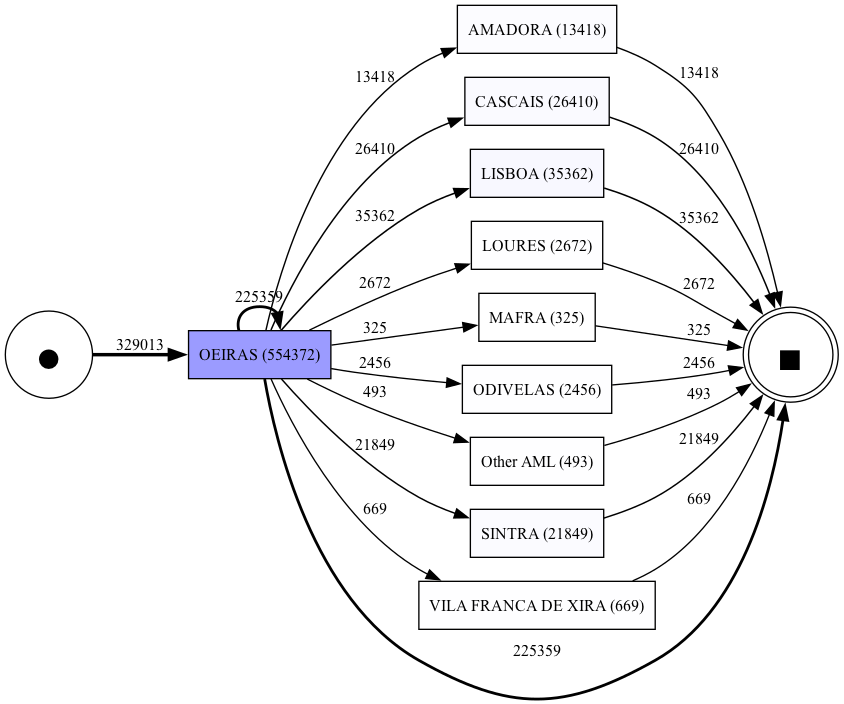

In [48]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log_municipality, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
pm4py.view_dfg(dfg, start_activities, end_activities, format='png')

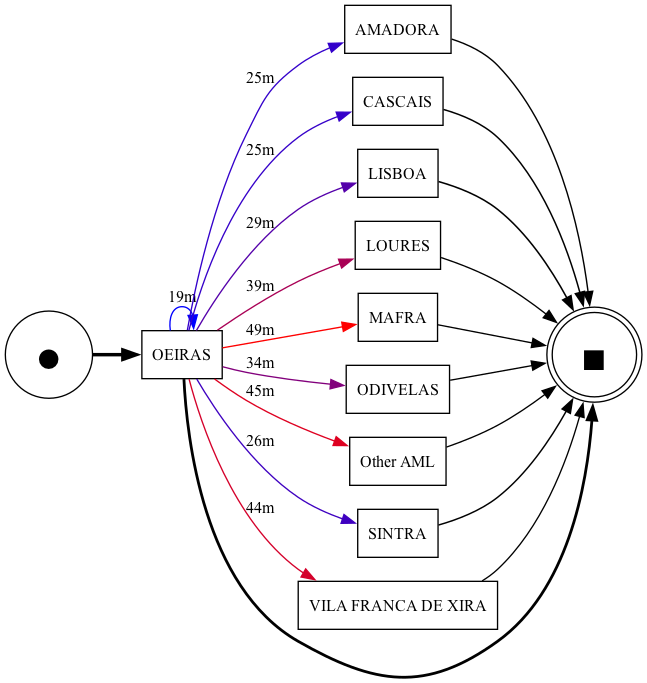

In [49]:
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log_municipality, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities, format='png')

In [ ]:
log_district_filtered = pm4py.filter_variants_top_k(
    log_district,
    20
)

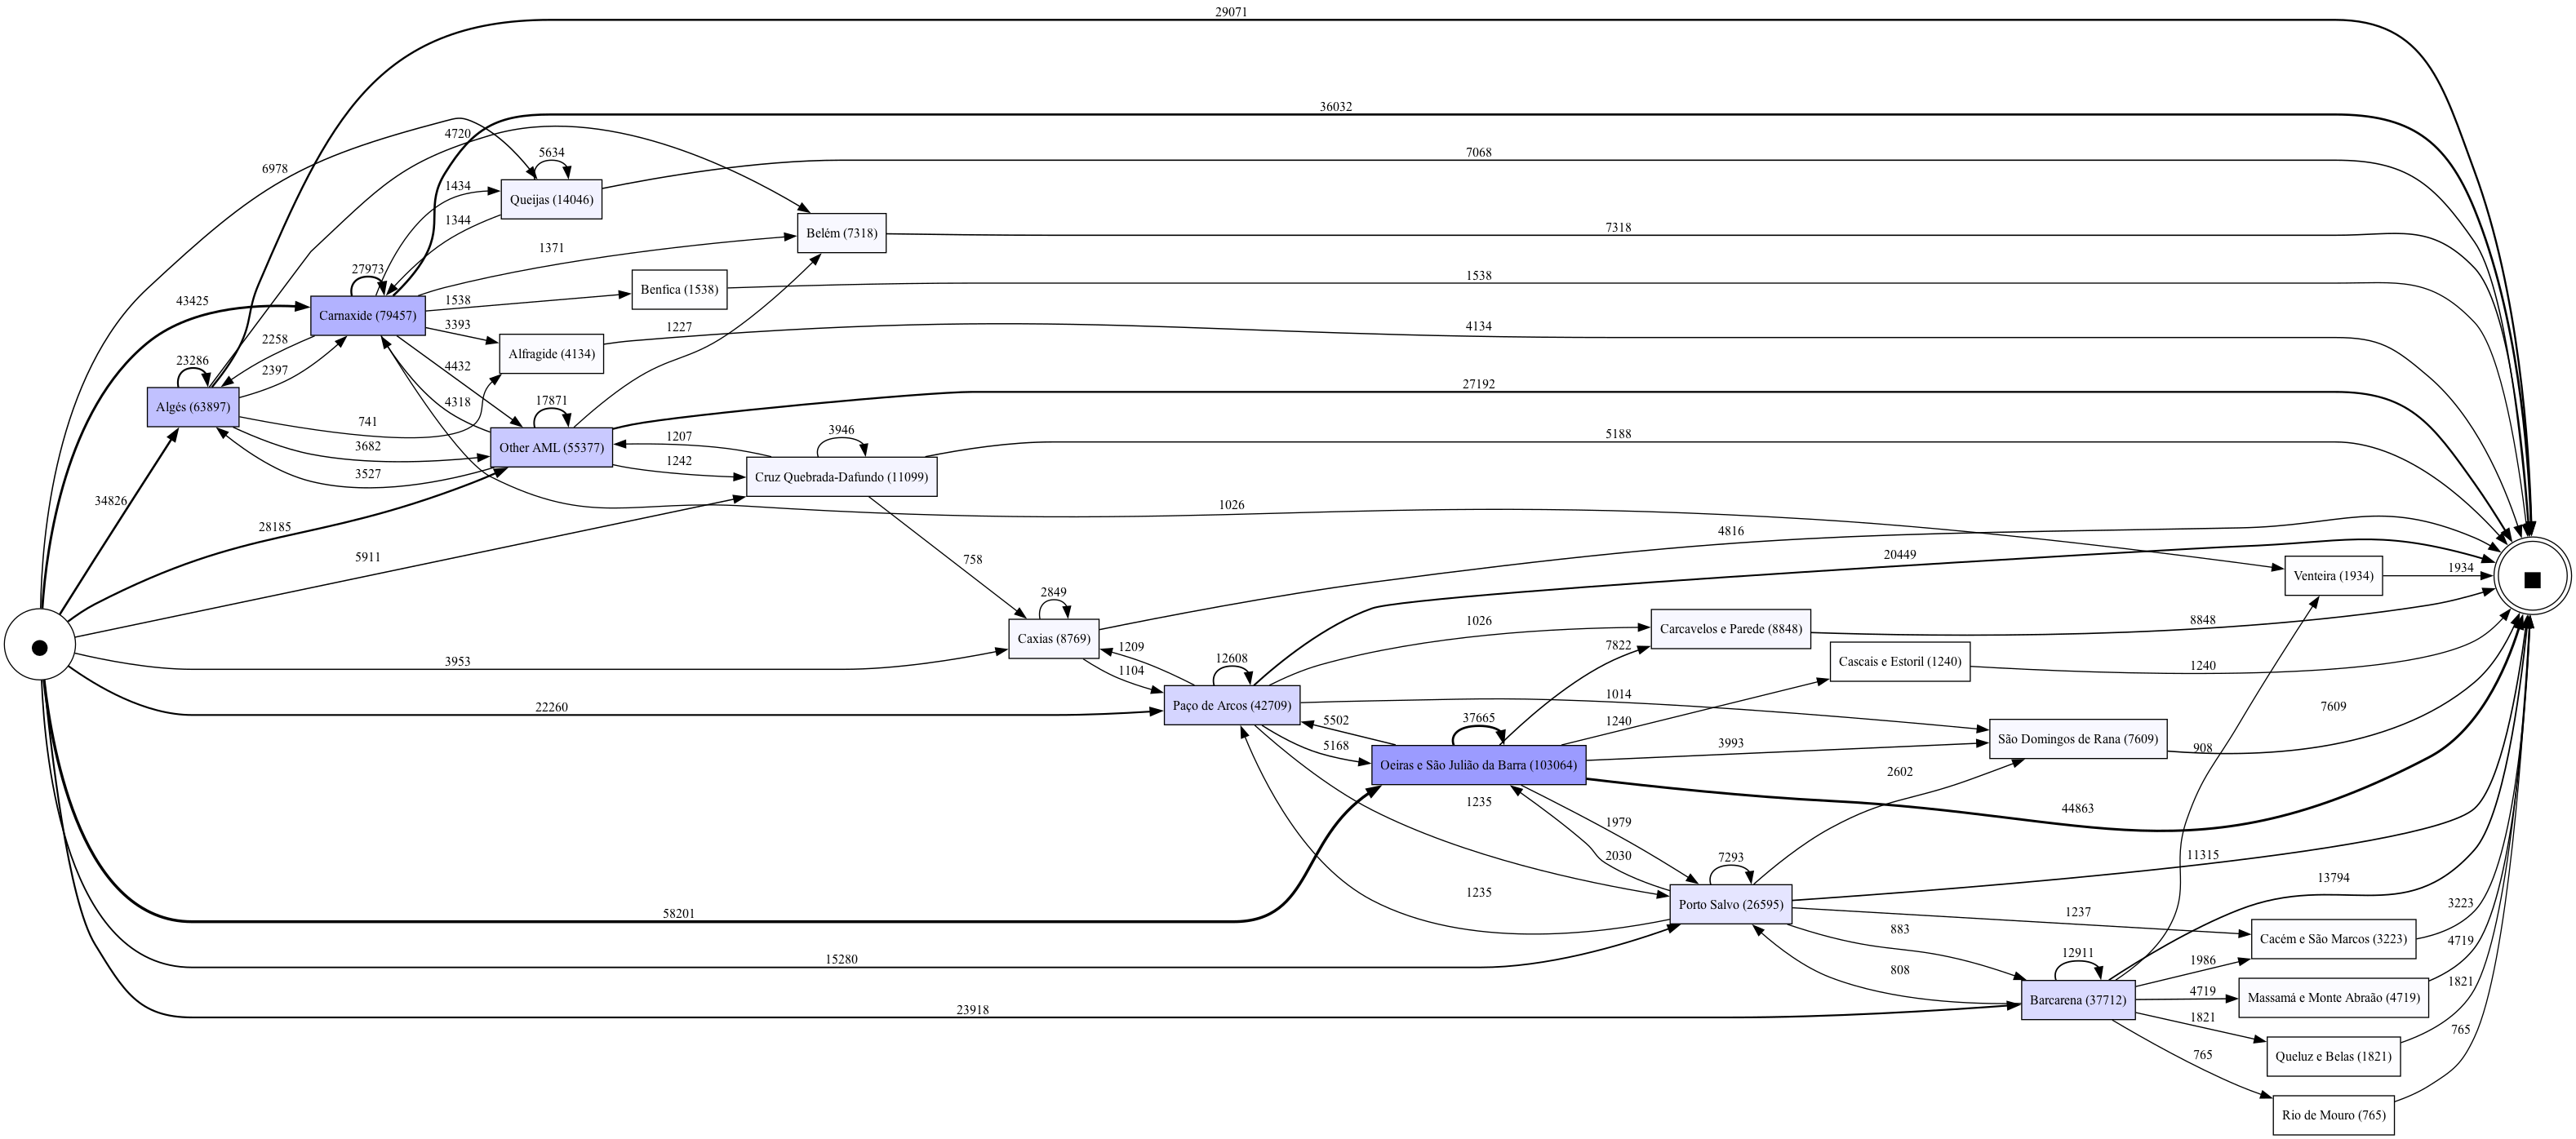

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log_district_filtered, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
pm4py.view_dfg(dfg, start_activities, end_activities, format='png')

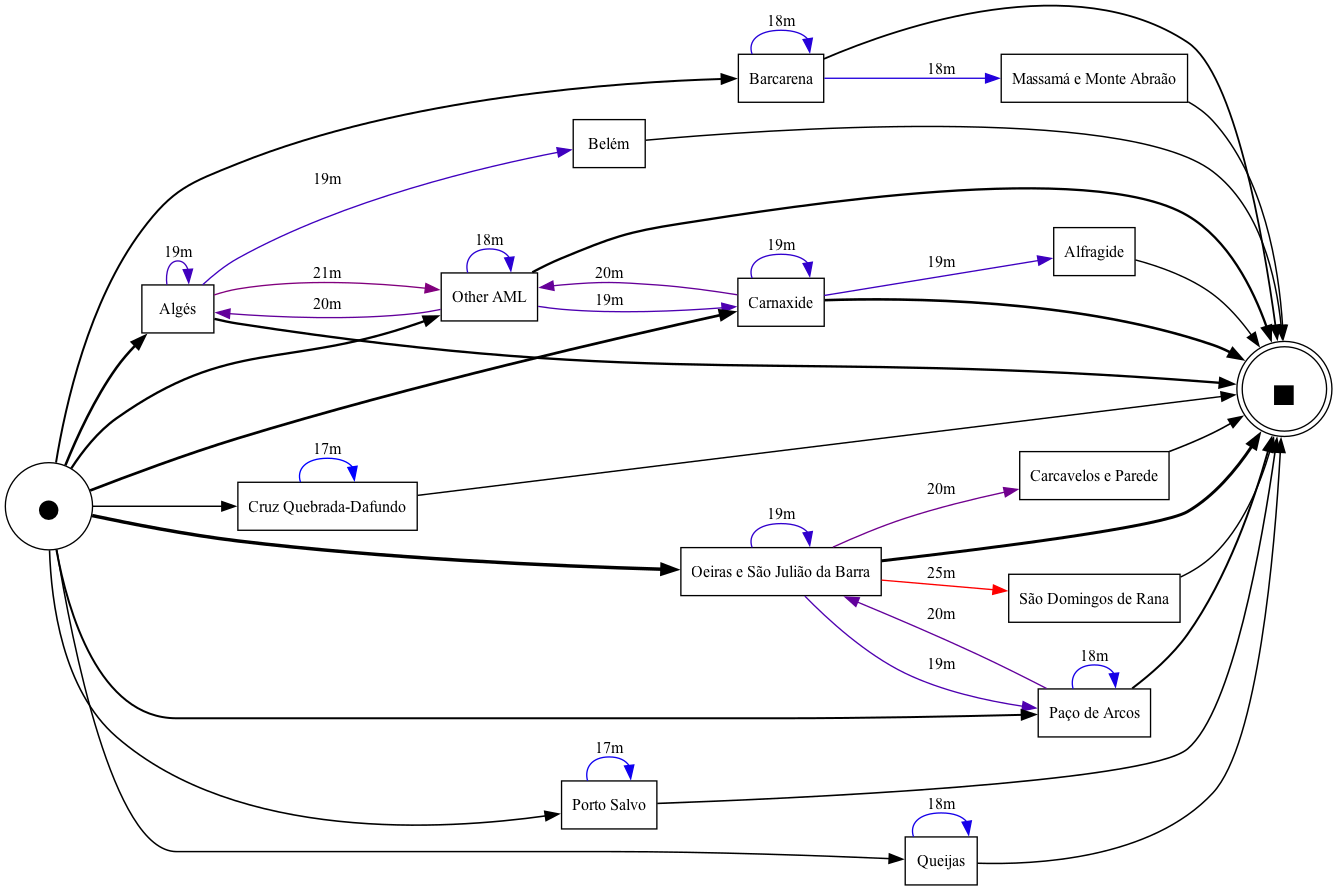

In [ ]:
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log_district_filtered, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities, format='png')

#### 9. Conformance Checking

In [26]:
pn, im, fm = pm4py.discover_petri_net_inductive(events_df_municipality)
pm4py.fitness_token_based_replay(events_df_municipality, pn, im, fm)

replaying log with TBR, completed traces :: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


{'perc_fit_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 1.0,
 'percentage_of_fitting_traces': 100.0}

In [24]:
pn, im, fm = pm4py.discover_petri_net_inductive(events_df_district)
pm4py.fitness_token_based_replay(events_df_municipality, pn, im, fm)

replaying log with TBR, completed traces :: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


{'perc_fit_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 1.0,
 'percentage_of_fitting_traces': 100.0}